In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

% matplotlib inline

In [136]:
df = pd.read_csv('video_stats.csv')
df['PublishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
df.dropna()
df['logViews'] = np.log(df['viewCount']+1)

In [4]:
df.columns

Index([u'viewCount', u'likeCount', u'dislikeCount', u'favoriteCount',
       u'commentCount', u'title', u'description', u'publishedAt', u'video Id',
       u'channel Id'],
      dtype='object')

High level overview of what I want to do is this:

The `prolific_channels` pandas dataframe has a bunch of entries corresponding to videos from channels that have published more than 50 videos. What I want to be able to do is, for each channel that has more than 50 videos, get the rowHash (index in the dataframe) of the most recently uploaded video. Then, for each of those most recently uploaded videos per channel, we want to get statistics for the last 10 or so videos uploaded before that one. Each of these stats will be a feature in our regression. And then after defining a dataframe for that (which I'll refer to as `df`) and putting those features in it, we call a GradientBoostingRegressor as follows.

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#features = ['last_video_views', '2nd_to_last_views', ... 'views_from_10_videos_ago',
#            'last_video_comment_count', same for the others...]

X = df[features]
y = df['Views']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
print "R^2: {0}".format(reg.score(X_test, y_test))

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=features)

And then in addition to that regressor, which is a view count predictor based on stats specific to the channel in question, we'll also want another regressor that looks at coarser channel stats like that other group did (total subscribers, total videos, total view counts, etc), and then just based on those try to come up with an estimate of the view counts for the most recent uploads to a channel. And then combine those regressors somehow.

In [137]:
channels = {}
for _, video in df.iterrows():
    channel_id = video['channel Id']
    if not channel_id in channels:
        channels[channel_id] = [video]
    else:
        channels[channel_id].append(video)
for channel_id in channels:
    channels[channel_id] = sorted(channels[channel_id], key=lambda v: v['PublishedAt'])

In [139]:
def prediction_answer_and_feature_extractor(channel, n):
    """
    I'm assuming the thing that's passed in is a list of videos,
    in other words a channel is a value in the channels dict.
    This also assumes that 
    
    This takes one of those entries and returns a tuple, one value of which
    is the correct view count that we want to predict for the most recent video
    posted to the channel, and the second is a dictionary containing feature names
    and feature values of the previous 10 videos before the most recent one.
    """
    if len(channel) < n+1:
        raise Exception("Not enough videos in channel to create a feature vector.")
        
    video_stat_names = ['likeCount', 'dislikeCount', 'viewCount', 
                        'favoriteCount', 'commentCount']
    correct_prediction = channel[-1]['logViews']
    feature_values = []
    feature_names = []
    for i in range(-2,-n-2,-1):
        feature_values += list(channel[i][video_stat_names])
        feature_names += [name + "%d"%(i+1) for name in video_stat_names]
    return (correct_prediction, dict(zip(feature_names, feature_values)))

The above will definitely fail since the entries in ~channels~ are often going to be shorter than n (which we'll set to 5 or 10 or something). Which is why we need to use the YouTube API to loop through all channel ids in channels and populate the list with the last 15 videos posted to that channel.

In [140]:
prolific_channels = {k:v for k, v in channels.items() if 11 < len(v)}

In [72]:
prediction_answer_and_feature_extractor(prolific_channels.iteritems()[0][1], 5)

(18.0,
 {'commentCount-1': 1.0,
  'commentCount-2': 2.0,
  'commentCount-3': 0.0,
  'commentCount-4': 0.0,
  'commentCount-5': 1.0,
  'dislikeCount-1': 3.0,
  'dislikeCount-2': 4.0,
  'dislikeCount-3': 0.0,
  'dislikeCount-4': 0.0,
  'dislikeCount-5': 0.0,
  'favoriteCount-1': 0,
  'favoriteCount-2': 0,
  'favoriteCount-3': 0,
  'favoriteCount-4': 0,
  'favoriteCount-5': 0,
  'likeCount-1': 81.0,
  'likeCount-2': 52.0,
  'likeCount-3': 0.0,
  'likeCount-4': 0.0,
  'likeCount-5': 6.0,
  'viewCount-1': 17389.0,
  'viewCount-2': 11175.0,
  'viewCount-3': 9.0,
  'viewCount-4': 18.0,
  'viewCount-5': 1499.0})

In [141]:
data = []
for channel_id, vids in prolific_channels.iteritems():
    answer, vid_features = prediction_answer_and_feature_extractor(vids, 10)
    vid_features['trueViewCount'] = answer
    data.append(vid_features)

In [55]:
channel

'UCa0o4WDOq1kJAyMETrPnpQg'

,commentCount-1,commentCount-10,commentCount-2,commentCount-3,commentCount-4,commentCount-5,commentCount-6,commentCount-7,commentCount-8,commentCount-9,...,viewCount-1,viewCount-10,viewCount-2,viewCount-3,viewCount-4,viewCount-5,viewCount-6,viewCount-7,viewCount-8,viewCount-9
0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,17389.0,71.0,11175.0,9.0,18.0,1499.0,14179.0,3485.0,6880.0,47.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,50.0,9.0,15.0,470.0,259.0,77.0,105.0,84.0,94.0
3,1.0,0.0,7.0,1.0,4.0,1.0,0.0,2.0,2.0,4.0,...,736.0,1430.0,4043.0,1321.0,587.0,464.0,1486.0,2111.0,1031.0,788.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,5.0,976.0,6.0,166.0,10.0,8.0,51.0,62.0,215.0,2302.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,108.0,35.0,95.0,138.0,51.0,352.0,145.0,62.0,64.0
6,1.0,0.0,0.0,0.0,0.0,6.0,2.0,4.0,0.0,0.0,...,3106.0,1512.0,1360.0,691.0,801.0,10934.0,10696.0,48737.0,4301.0,5243.0
7,1.0,0.0,12.0,1.0,0.0,10.0,14.0,12.0,0.0,11.0,...,106.0,99.0,1467.0,946.0,273.0,541.0,1024.0,573.0,224.0,497.0
8,0.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,...,167.0,284.0,52.0,25.0,81.0,104.0,394.0,213.0,372.0,134.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,350.0,167.0,25.0,209.0,55.0,96.0,247.0,61.0,186.0
10,0.0,5.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,133.0,3719.0,188.0,1603.0,680.0,233.0,563.0,235.0,788.0,18886.0


In [80]:
Y = pd.DataFrame(answers)

In [87]:
df.columns

Index([u'commentCount-1', u'commentCount-10', u'commentCount-2',
       u'commentCount-3', u'commentCount-4', u'commentCount-5',
       u'commentCount-6', u'commentCount-7', u'commentCount-8',
       u'commentCount-9', u'dislikeCount-1', u'dislikeCount-10',
       u'dislikeCount-2', u'dislikeCount-3', u'dislikeCount-4',
       u'dislikeCount-5', u'dislikeCount-6', u'dislikeCount-7',
       u'dislikeCount-8', u'dislikeCount-9', u'favoriteCount-1',
       u'favoriteCount-10', u'favoriteCount-2', u'favoriteCount-3',
       u'favoriteCount-4', u'favoriteCount-5', u'favoriteCount-6',
       u'favoriteCount-7', u'favoriteCount-8', u'favoriteCount-9',
       u'likeCount-1', u'likeCount-10', u'likeCount-2', u'likeCount-3',
       u'likeCount-4', u'likeCount-5', u'likeCount-6', u'likeCount-7',
       u'likeCount-8', u'likeCount-9', u'trueViewCount', u'viewCount-1',
       u'viewCount-10', u'viewCount-2', u'viewCount-3', u'viewCount-4',
       u'viewCount-5', u'viewCount-6', u'viewCount-7', u'vi

R^2: 0.611319804177


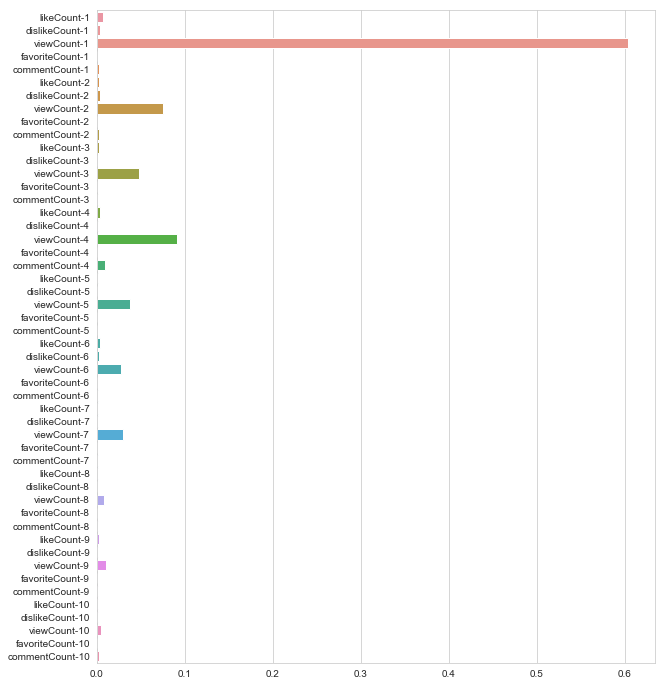

In [145]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

features = ['likeCount', 'dislikeCount', 'viewCount', 
                        'favoriteCount', 'commentCount']
real_features = [name+'-%d'%i for i in range(1,11) for name in features]
df = pd.DataFrame(data)
df = df.dropna()
X = df[real_features]
y = df['trueViewCount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
print "R^2: {0}".format(reg.score(X_test, y_test))
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=real_features)

In [112]:
X

,likeCount-1,dislikeCount-1,viewCount-1,favoriteCount-1,commentCount-1,likeCount-2,dislikeCount-2,viewCount-2,favoriteCount-2,commentCount-2,...,likeCount-9,dislikeCount-9,viewCount-9,favoriteCount-9,commentCount-9,likeCount-10,dislikeCount-10,viewCount-10,favoriteCount-10,commentCount-10
0,81.0,3.0,17389.0,0,1.0,52.0,4.0,11175.0,0,2.0,...,0.0,0.0,47.0,0,0.0,0.0,0.0,71.0,0,1.0
2,0.0,0.0,6.0,0,0.0,0.0,0.0,9.0,0,0.0,...,0.0,0.0,94.0,0,0.0,0.0,0.0,50.0,0,0.0
3,14.0,1.0,736.0,0,1.0,28.0,4.0,4043.0,0,7.0,...,10.0,2.0,788.0,0,4.0,14.0,3.0,1430.0,0,0.0
4,0.0,0.0,5.0,0,0.0,0.0,0.0,6.0,0,0.0,...,1.0,4.0,2302.0,0,2.0,1.0,2.0,976.0,0,0.0
5,0.0,0.0,89.0,0,0.0,0.0,0.0,35.0,0,0.0,...,1.0,0.0,64.0,0,0.0,0.0,1.0,108.0,0,0.0
6,1.0,0.0,3106.0,0,1.0,0.0,0.0,1360.0,0,0.0,...,2.0,0.0,5243.0,0,0.0,1.0,0.0,1512.0,0,0.0
7,3.0,0.0,106.0,0,1.0,28.0,0.0,1467.0,0,12.0,...,7.0,3.0,497.0,0,11.0,1.0,0.0,99.0,0,0.0
8,4.0,0.0,167.0,0,0.0,0.0,0.0,52.0,0,0.0,...,0.0,1.0,134.0,0,0.0,2.0,1.0,284.0,0,1.0
9,0.0,0.0,29.0,0,0.0,1.0,0.0,167.0,0,0.0,...,0.0,0.0,186.0,0,0.0,0.0,0.0,350.0,0,0.0
10,1.0,0.0,133.0,0,0.0,0.0,0.0,188.0,0,1.0,...,6.0,35.0,18886.0,0,0.0,3.0,0.0,3719.0,0,5.0


In [95]:
df = df.dropna()

In [96]:
df

,commentCount-1,commentCount-10,commentCount-2,commentCount-3,commentCount-4,commentCount-5,commentCount-6,commentCount-7,commentCount-8,commentCount-9,...,viewCount-1,viewCount-10,viewCount-2,viewCount-3,viewCount-4,viewCount-5,viewCount-6,viewCount-7,viewCount-8,viewCount-9
0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,17389.0,71.0,11175.0,9.0,18.0,1499.0,14179.0,3485.0,6880.0,47.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,50.0,9.0,15.0,470.0,259.0,77.0,105.0,84.0,94.0
3,1.0,0.0,7.0,1.0,4.0,1.0,0.0,2.0,2.0,4.0,...,736.0,1430.0,4043.0,1321.0,587.0,464.0,1486.0,2111.0,1031.0,788.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,5.0,976.0,6.0,166.0,10.0,8.0,51.0,62.0,215.0,2302.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,108.0,35.0,95.0,138.0,51.0,352.0,145.0,62.0,64.0
6,1.0,0.0,0.0,0.0,0.0,6.0,2.0,4.0,0.0,0.0,...,3106.0,1512.0,1360.0,691.0,801.0,10934.0,10696.0,48737.0,4301.0,5243.0
7,1.0,0.0,12.0,1.0,0.0,10.0,14.0,12.0,0.0,11.0,...,106.0,99.0,1467.0,946.0,273.0,541.0,1024.0,573.0,224.0,497.0
8,0.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,...,167.0,284.0,52.0,25.0,81.0,104.0,394.0,213.0,372.0,134.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,350.0,167.0,25.0,209.0,55.0,96.0,247.0,61.0,186.0
10,0.0,5.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,133.0,3719.0,188.0,1603.0,680.0,233.0,563.0,235.0,788.0,18886.0


0.6179862204046102


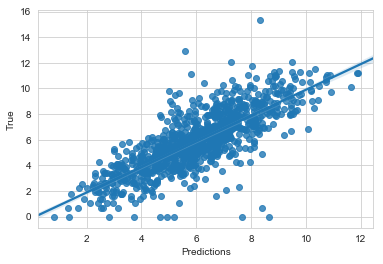

In [148]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
print xgb.score(X_test, y_test)
y_pred = xgb.predict(X_test)
plot_df = pd.DataFrame(y_pred, columns=['Predictions'])
plot_df['True'] = np.array(y_test)
sns.regplot(x='Predictions', y='True', data=plot_df)